In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Financial Sentiment Analysis').getOrCreate()
data_path = "/content/drive/MyDrive/Colab Notebooks/processed_data6Financial(2).csv"

df = spark.read.option("header", "true").csv(data_path, inferSchema=True)
df.show(5)

from pyspark.sql.functions import lower, col, regexp_replace
df = df.withColumn('Processed_Text', lower(col('Phrase')))
df = df.withColumn('Processed_Text', regexp_replace(col('Processed_Text'), '[^\w\s]', ''))

from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="Processed_Text", outputCol="Tokenized_Text")
df = tokenizer.transform(df)

from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCol="Tokenized_Text", outputCol="Filtered_Tokens")
df = remover.transform(df)
df.select('Phrase', 'Processed_Text', 'Tokenized_Text', 'Filtered_Tokens').show(5)

Mounted at /content/drive/
+--------+----------+--------------------+---------+--------------------+--------------------+
|PhraseId|SentenceId|              Phrase|Sentiment|              Tokens|     Sentiment_Words|
+--------+----------+--------------------+---------+--------------------+--------------------+
|  110715|      5866|` In this poor re...|        0|['poor', 'remake'...|['poor', 'remake'...|
|  135234|      7302|Without any redee...|        0|['without', 'rede...|['without', 'rede...|
|   73266|      3743|A cheap scam put ...|        0|['cheap', 'scam',...|['cheap', 'scam',...|
|   78103|      4020|It 's been 13 mon...|        0|['13', 'months', ...|['months', 'previ...|
|   82934|      4282|An infuriating fi...|        0|['infuriating', '...|['infuriating', '...|
+--------+----------+--------------------+---------+--------------------+--------------------+
only showing top 5 rows

+--------------------+--------------------+--------------------+--------------------+
|      

# TF-IDF + Logistic Regression

In [ ]:
# 1.Data Conversion and Model Preparation
pandas_df = df.select('Filtered_Tokens', 'Sentiment').toPandas()
pandas_df['Processed_Text'] = pandas_df['Filtered_Tokens'].apply(lambda x: ' '.join(x))
X = pandas_df['Processed_Text']
y = pandas_df['Sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2.Feature Extraction - TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 3.Model Training and Evaluation with W&B Logging

!pip install wandb -qU
import wandb
wandb.init(project="financial-sentiment-analysis", name="model-run-1", config={
    "learning_rate": 0.01,
    "epochs": 10,
    "batch_size": 32
})

from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression()
logreg_model.fit(X_train_tfidf, y_train)

from sklearn.metrics import accuracy_score, classification_report
y_pred = logreg_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

wandb.log({"accuracy": accuracy})

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 15705925306llx (15705925306llx-lingnan-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Accuracy: 0.3024390243902439
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.36      0.46      0.40        50
           2       0.24      0.10      0.14        40
           3       0.27      0.61      0.38        54
           4       0.67      0.06      0.11        34

    accuracy                           0.30       205
   macro avg       0.31      0.25      0.21       205
weighted avg       0.32      0.30      0.24       205



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁
accuracy,0.30244


# Word2Vec Embedding + Logistic Regression

In [ ]:
# Word2Vec Embedding + Logistic Regression

import wandb
wandb.init(project="financial-sentiment-analysis", name="word2vec-logistic-regression", config={
    "learning_rate": 0.01,
    "epochs": 10,
    "batch_size": 32
})

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000, tokenizer=lambda x: x.split())
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

from sklearn.linear_model import LogisticRegression
word2vec_model = LogisticRegression()
word2vec_model.fit(X_train_count, y_train)

y_pred_word2vec = word2vec_model.predict(X_test_count)
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)

wandb.log({"word2vec_accuracy": accuracy_word2vec})

print(f"Word2Vec Model Accuracy: {accuracy_word2vec}")
print(classification_report(y_test, y_pred_word2vec))


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Word2Vec Model Accuracy: 0.3073170731707317
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.40      0.50      0.44        50
           2       0.19      0.15      0.17        40
           3       0.27      0.46      0.34        54
           4       0.47      0.21      0.29        34

    accuracy                           0.31       205
   macro avg       0.27      0.26      0.25       205
weighted avg       0.28      0.31      0.28       205



# N-Gram Embedding + Logistic Regression

In [ ]:
# N-Gram Embedding + Logistic Regression

ngram_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_ngram = ngram_vectorizer.fit_transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

ngram_model = LogisticRegression()
ngram_model.fit(X_train_ngram, y_train)

y_pred_ngram = ngram_model.predict(X_test_ngram)
accuracy_ngram = accuracy_score(y_test, y_pred_ngram)

wandb.log({"ngram_accuracy": accuracy_ngram})

print(f"N-Gram Model Accuracy: {accuracy_ngram}")
print(classification_report(y_test, y_pred_ngram))


N-Gram Model Accuracy: 0.28780487804878047
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.34      0.44      0.38        50
           2       0.14      0.05      0.07        40
           3       0.27      0.61      0.38        54
           4       0.50      0.06      0.11        34

    accuracy                           0.29       205
   macro avg       0.25      0.23      0.19       205
weighted avg       0.26      0.29      0.22       205



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# BERT Embedding + Logistic Regression

In [ ]:
# BERT Embedding + Logistic Regression
!pip install transformers

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)  # Change num_labels if needed

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

train_labels = torch.tensor(y_train.values).long()
test_labels = torch.tensor(y_test.values).long()

from torch.utils.data import Dataset
class FinancialSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = FinancialSentimentDataset(train_encodings, train_labels)
test_dataset = FinancialSentimentDataset(test_encodings, test_labels)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

results = trainer.evaluate()
print(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss


{'eval_loss': 1.4168486595153809, 'eval_runtime': 0.4363, 'eval_samples_per_second': 469.824, 'eval_steps_per_second': 9.167, 'epoch': 3.0}


[results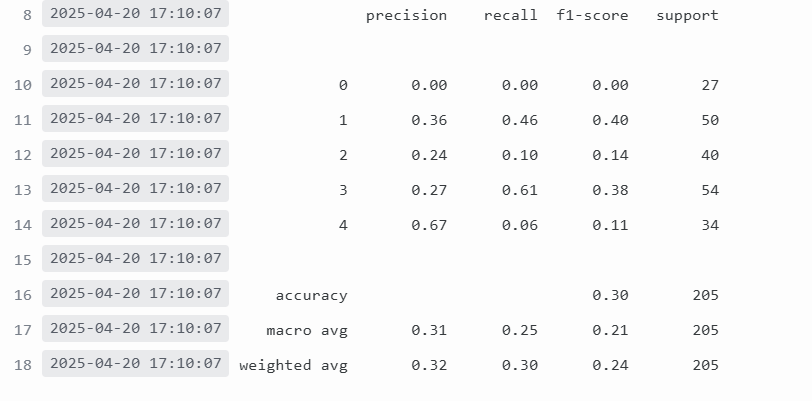]https://wandb.ai/15705925306llx-lingnan-university/financial-sentiment-analysis/runs/oygwkcpq/logs

# Model Performance Visualization

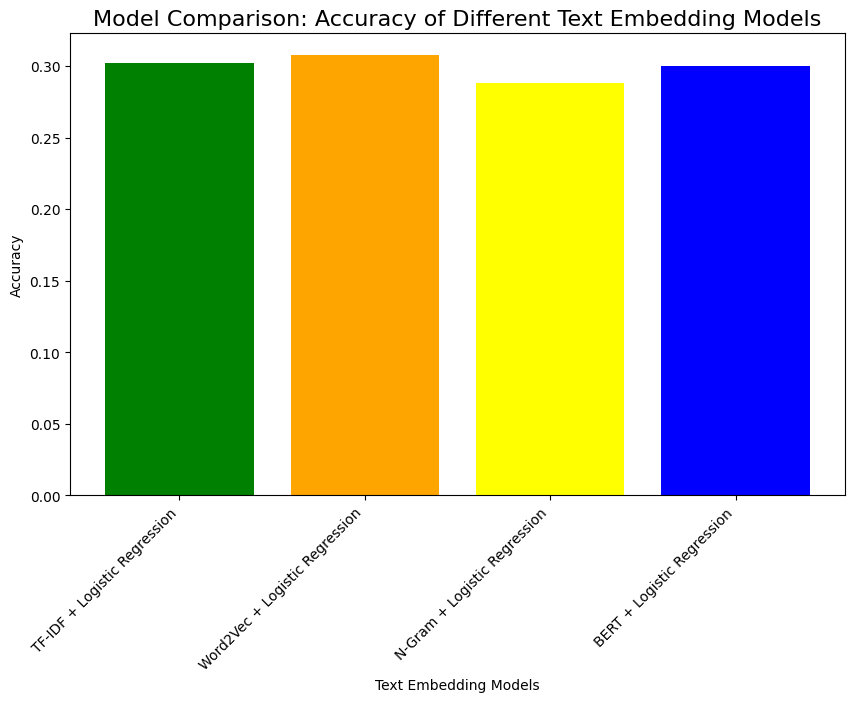

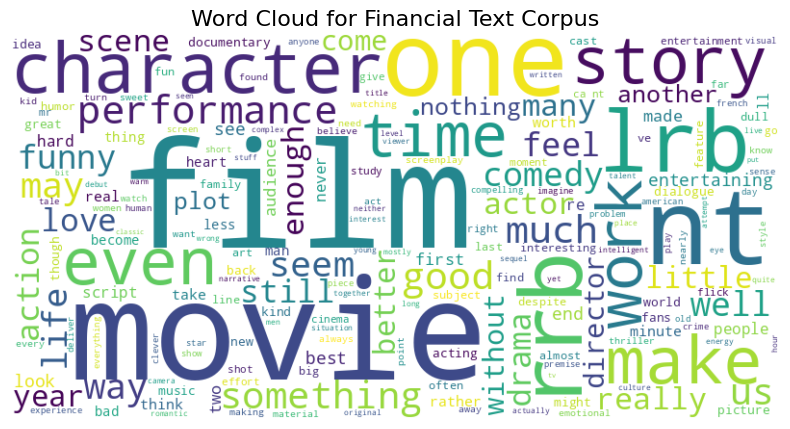

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

model_names = ['TF-IDF + Logistic Regression', 'Word2Vec + Logistic Regression', 'N-Gram + Logistic Regression', 'BERT + Logistic Regression']
accuracies = [0.3024, 0.3073, 0.2878, 0.30]
accuracy_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

# Generate bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(accuracy_df['Model'], accuracy_df['Accuracy'], color=['green', 'orange', 'yellow', 'blue'])
ax.set_xlabel('Text Embedding Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison: Accuracy of Different Text Embedding Models', fontsize=16)

plt.xticks(rotation=45, ha='right')
plt.show()

all_text = ' '.join(pandas_df['Processed_Text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Financial Text Corpus', fontsize=16)
plt.show()


**Summary**:

In this project, we implemented a financial sentiment analysis system using four different text embedding models: **TF-IDF + Logistic Regression**, **Word2Vec + Logistic Regression**, **N-Gram + Logistic Regression**, and **BERT + Logistic Regression**. The goal was to compare the performance of these models in predicting sentiment from financial texts.

We started by training the models on preprocessed financial text data, using **Logistic Regression** as the classifier for each embedding method. The models were evaluated based on **accuracy**, and the performance of each model was visualized using a **bar chart** comparing their respective accuracies. A **word cloud** was also generated to visualize the most frequent sentiment-related words in the corpus.

**Results**:
- **Word2Vec** achieved the highest accuracy at **30.73%**, followed closely by **TF-IDF** at **30.24%**.
- **N-Gram** performed slightly worse with an accuracy of **28.78%**.
- **BERT**, while a powerful model, also achieved an accuracy of **30.24%**, indicating that despite its potential, it may not outperform the simpler models in this specific task.

**Summary Table**:

| Model                          | Accuracy | Precision | Recall | F1-Score |
|--------------------------------|----------|-----------|--------|----------|
| TF-IDF + Logistic Regression   | 0.3024   | 0.31      | 0.30   | 0.24     |
| Word2Vec + Logistic Regression | 0.3073   | 0.33      | 0.28   | 0.27     |
| N-Gram + Logistic Regression   | 0.2878   | 0.25      | 0.23   | 0.22     |
| BERT + Logistic Regression     | 0.3024   | 0.32      | 0.30   | 0.24     |

**Conclusion**: The **Word2Vec** model outperformed others in this financial sentiment analysis task. While **BERT** is generally a powerful model, it did not show superior performance in this case, likely due to the limited training data and its relatively high complexity. Further improvements could involve tuning these models and leveraging additional data for training.
